<a href="https://colab.research.google.com/github/wiatrak2/BScThesis/blob/master/mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading data

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('BScThesis/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip3 install torch torchvision

In [71]:
from importlib import reload 
reload(trainer)

<module 'trainer' from 'BScThesis/trainer.py'>

In [3]:
!git clone https://github.com/wiatrak2/BScThesis

Cloning into 'BScThesis'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 184 (delta 1), reused 2 (delta 0), pack-reused 179
Receiving objects: 100% (184/184), 15.10 MiB | 6.03 MiB/s, done.
Resolving deltas: 100% (100/100), done.


In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
import torchvision
import torchvision.transforms as transforms

In [0]:
import matplotlib.pyplot as plt
import pickle
import sympy
from collections import defaultdict, namedtuple
import copy

In [0]:
from mnist_m import Mnist_M
from datasets_merge import Merge_Datasets
import models
import trainer
import domain_trainer
from test_model import test_model
import plots
import test

In [0]:
def convertMnist(img):
  img = img.squeeze().numpy()
  return torch.from_numpy(np.tile(img, (3,1,1)))

In [0]:
batch_size=128
num_workers=1

In [10]:
transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,)),
                           transforms.Lambda(convertMnist)
                       ])

train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True,
                                     transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)

test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True,
                                     transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)


Processing...
Done!


In [0]:
def printMnist3D(image):
  image = image.numpy()
  image = image * 0.3081 + 0.1307
  plt.imshow(image.transpose(1,2,0), cmap='gray')

7


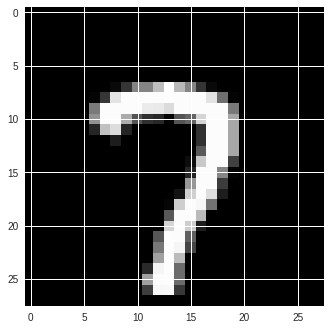

In [12]:
trainiter = iter(train_loader)
images, labels = trainiter.next()

sample = images[0]
printMnist3D(sample)
print(labels[0].item())

In [0]:
log_interval = 100

In [0]:
use_cuda = True
use_cuda = use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [0]:
lr = 0.01
momentum=0.9

In [0]:
mnist_m_transform = transforms.Compose([
                           transforms.Normalize(3*[0.1307], 3*[0.3081]),
                       ])
mnist_m_train = Mnist_M('drive/My Drive/BScThesis/keras_mnistm.pkl',
                        transform=mnist_m_transform)
mnist_m_test = Mnist_M('drive/My Drive/BScThesis/keras_mnistm.pkl',train=False,
                     transform=mnist_m_transform)
mnist_m_train_loader = torch.utils.data.DataLoader(mnist_m_train, 
                                                   batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)
mnist_m_test_loader = torch.utils.data.DataLoader(mnist_m_test,
                                                  batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)


tensor(1)


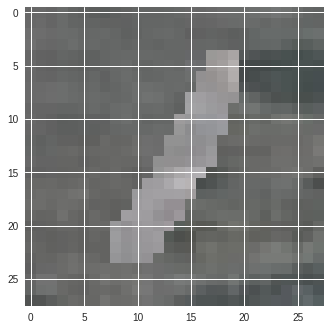

In [17]:
trainiter = iter(mnist_m_train_loader)
images, labels = trainiter.next()
printMnist3D(images[0])
print(labels[0])

In [0]:
Models = namedtuple('Models', ['model_f', 'model_c', 'model_d'])
Optims = namedtuple('Optims', ['optim_f', 'optim_c', 'optim_d'])
Criterions = namedtuple('Criterions', ['criterion', 'criterion_domain'])
Loaders = namedtuple('Loaders', ['train_loader', 'train_loader_domain',
                                'source_test_loader', 'target_test_loader',
                                'merged_test_loader'])

In [0]:
mnist_ext_train = Merge_Datasets([train_set, mnist_m_train])
mnist_ext_test = Merge_Datasets([test_set, mnist_m_test])
mnist_ext_train_loader = torch.utils.data.DataLoader(mnist_ext_train, 
                                                   batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)
mnist_ext_test_loader = torch.utils.data.DataLoader(mnist_ext_test, 
                                                   batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)



In [0]:
loaders = Loaders(train_loader, mnist_m_train_loader,
                 test_loader, mnist_m_test_loader, mnist_ext_test_loader)

In [0]:
criterion = F.nll_loss
criterion_domain = F.nll_loss

In [0]:
criterions = Criterions(criterion, criterion_domain)

In [0]:
epochs=10

# First training

In [0]:
model_f = models.MnistFeatureExtractor().to(device)
model_c = models.MnistClassPredictor().to(device)
model_d = models.MnistDomain().to(device)
optim_f = optim.SGD(model_f.parameters(), lr=lr, momentum=momentum, nesterov=True)
optim_c = optim.SGD(model_c.parameters(), lr=lr, momentum=momentum, nesterov=True)
optim_d = optim.SGD(model_d.parameters(), lr=lr, momentum=momentum, nesterov=True)

train_models = Models(model_f, model_c, model_d)
optims = Optims(optim_f, optim_c, optim_d)

In [0]:
model_trainer = trainer.Trainer(train_models, optims, criterions, device,
                                tune_lr=True)

In [26]:
test_history = defaultdict(lambda:[])
model_trainer.train(epochs, loaders, test_history=test_history)

Train Epoch: 					1 [0/60000 (0%)]	Loss: 2.301300, lr: 0.01000 lambd: 0.00000
Train Epoch: 					1 [12800/60000 (21%)]	Loss: 0.810424, lr: 0.00865 lambd: 0.10626
Train Epoch: 					1 [25600/60000 (43%)]	Loss: 0.630064, lr: 0.00766 lambd: 0.21015
Train Epoch: 					1 [38400/60000 (64%)]	Loss: 0.413419, lr: 0.00690 lambd: 0.30951
Train Epoch: 					1 [51200/60000 (85%)]	Loss: 0.345273, lr: 0.00630 lambd: 0.40253

Target Domain Test set: Average loss: 1.3247, Accuracy: 5980/10000 (60%)

Source Domain Test set: Average loss: 0.1049, Accuracy: 9686/10000 (97%)

Domains predictor:  Accuracy: 15614/20000 (78%)

Train Epoch: 					2 [0/60000 (0%)]	Loss: 0.355543, lr: 0.00595 lambd: 0.46212
Train Epoch: 					2 [12800/60000 (21%)]	Loss: 0.240586, lr: 0.00551 lambd: 0.54178
Train Epoch: 					2 [25600/60000 (43%)]	Loss: 0.318143, lr: 0.00514 lambd: 0.61276
Train Epoch: 					2 [38400/60000 (64%)]	Loss: 0.434283, lr: 0.00483 lambd: 0.67507
Train Epoch: 					2 [51200/60000 (85%)]	Loss: 0.236464, lr: 0.004

In [27]:
mnist_pred = nn.Sequential(model_f, model_c)
test_model(mnist_pred, device, criterions, mnist_m_test_loader)


Test set: Average loss: 0.7791, Accuracy: 7695/10000 (77%)



In [28]:
mnist_pred = nn.Sequential(model_f, model_c)
test_model(mnist_pred, device, criterions, test_loader)


Test set: Average loss: 0.0549, Accuracy: 9831/10000 (98%)



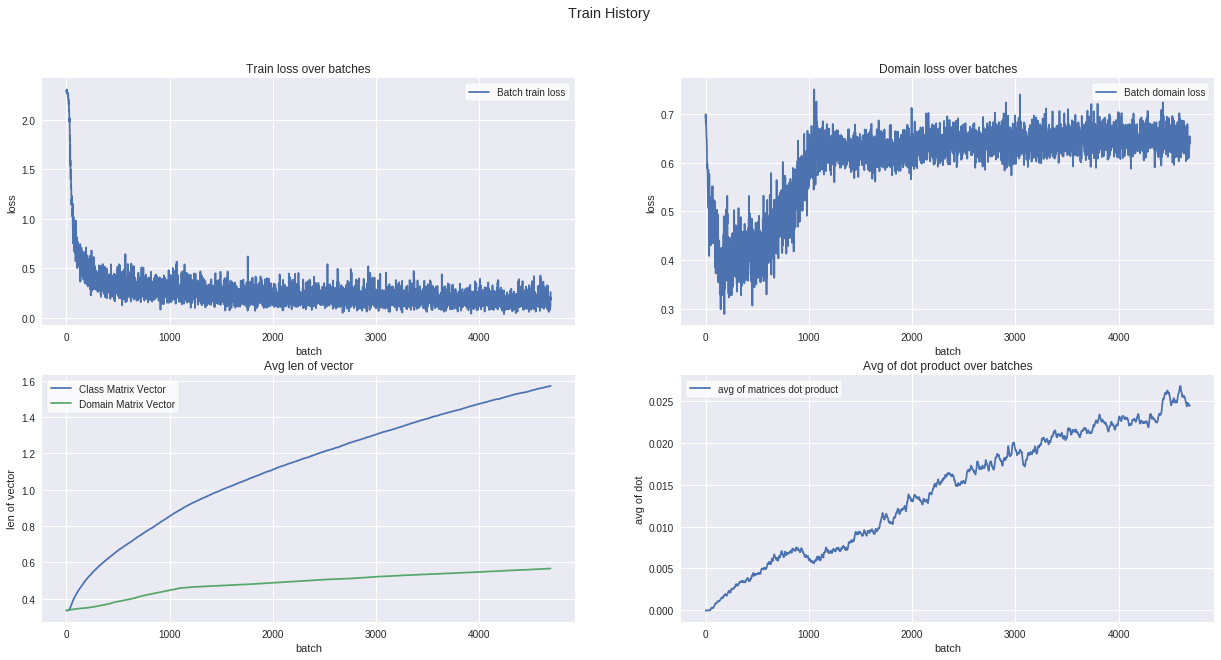

In [29]:
plots.plot_training(model_trainer.train_history)

In [30]:
model_trainer.get_best_model()

(Models(model_f=MnistFeatureExtractor(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
), model_c=MnistClassPredictor(
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
), model_d=MnistDomain(
  (fc1): Linear(in_features=320, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)),
 76.95)

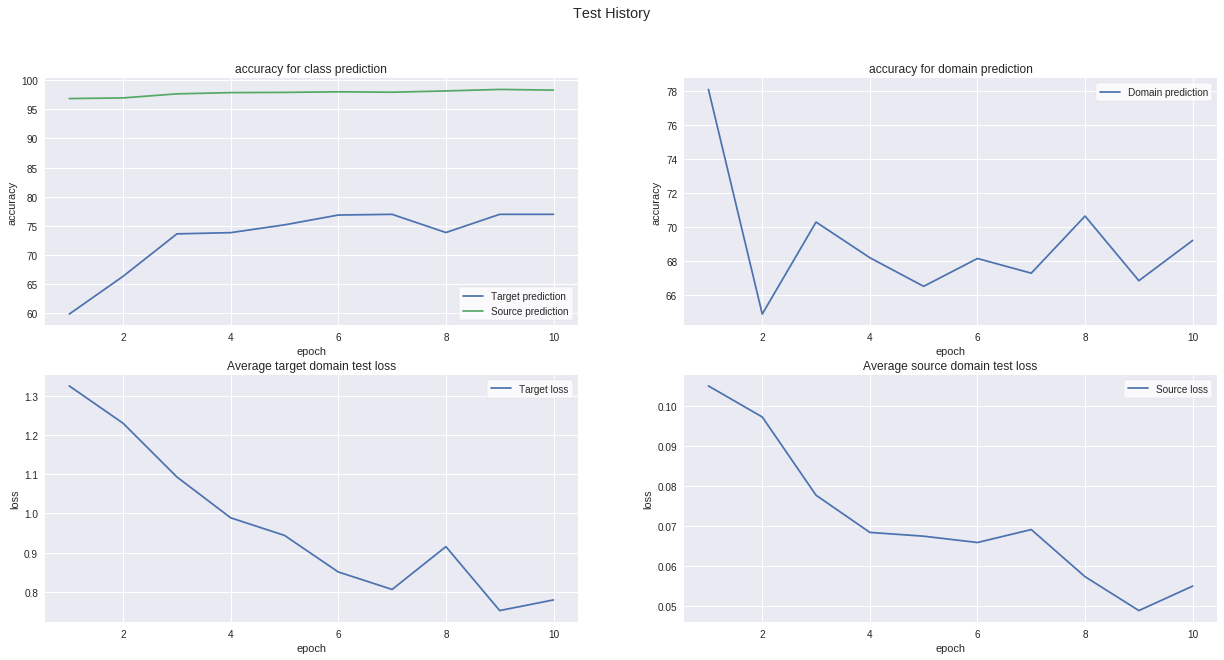

In [31]:
plots.plot_test(test_history)

# Domain Prediction on feature extractor representation

In [0]:
domain_pred = models.DomainPredictor().to(device)
domain_optim = optim.SGD(domain_pred.parameters(), lr=lr, momentum=momentum)

In [0]:
models_dom = Models(model_f, None, domain_pred)
optims_dom = Optims(None, None, optim_d=domain_optim)
mnist_domain_trainer = domain_trainer.DomainTrainer(models_dom, optims_dom, criterions, device)

In [34]:
domain_train_history = defaultdict(lambda:[])
mnist_domain_trainer.train(4, loaders, train_models, train_history=domain_train_history)

Train Epoch: 1 [0/20000 (0%)]	Loss: 0.790001

Domains predictor:  Accuracy: 16418/20000 (82%)

Train Epoch: 2 [0/20000 (0%)]	Loss: 0.476041

Domains predictor:  Accuracy: 17428/20000 (87%)

Train Epoch: 3 [0/20000 (0%)]	Loss: 0.379395

Domains predictor:  Accuracy: 18021/20000 (90%)

Train Epoch: 4 [0/20000 (0%)]	Loss: 0.320875

Domains predictor:  Accuracy: 18453/20000 (92%)



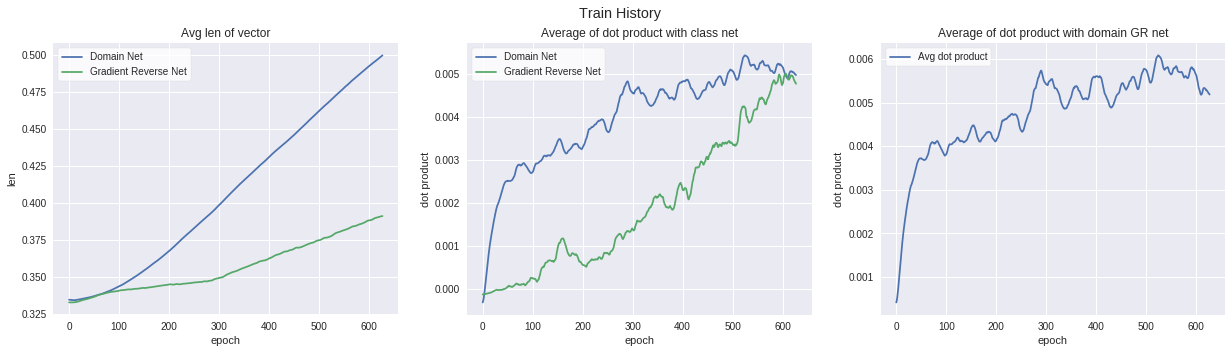

In [35]:
plots.plot_domain_training(domain_train_history, model_trainer.train_history)

# Different types of training continuation

## Minimize dot product of class and domain *predictors*

In [0]:
def mtx_dot(model_f, model_c, model_d, *args):
  return torch.mean(torch.pow(torch.mm(model_c.get_mtx().weight, torch.transpose(model_d.get_mtx().weight, 0, 1)), 2))

In [0]:
trainer_next = copy.deepcopy(model_trainer)

In [38]:
test_history2 = defaultdict(lambda:[])
trainer_next.train(7, loaders, mtx_dot, test_history=test_history2)

Train Epoch: 					1 [0/60000 (0%)]	Loss: 0.084485, p: 0.00000 lambd: 0.00000
Train Epoch: 					1 [12800/60000 (21%)]	Loss: 0.147296, p: 0.03048 lambd: 0.15121
Train Epoch: 					1 [25600/60000 (43%)]	Loss: 0.219194, p: 0.06095 lambd: 0.29566
Train Epoch: 					1 [38400/60000 (64%)]	Loss: 0.230928, p: 0.09143 lambd: 0.42775
Train Epoch: 					1 [51200/60000 (85%)]	Loss: 0.251037, p: 0.12190 lambd: 0.54379

Target Domain Test set: Average loss: 0.7551, Accuracy: 7704/10000 (77%)

Source Domain Test set: Average loss: 0.0630, Accuracy: 9807/10000 (98%)

Domains predictor:  Accuracy: 13603/20000 (68%)

Train Epoch: 					2 [0/60000 (0%)]	Loss: 0.268460, p: 0.14286 lambd: 0.61336
Train Epoch: 					2 [12800/60000 (21%)]	Loss: 0.181087, p: 0.17333 lambd: 0.69968
Train Epoch: 					2 [25600/60000 (43%)]	Loss: 0.216293, p: 0.20381 lambd: 0.76948
Train Epoch: 					2 [38400/60000 (64%)]	Loss: 0.168820, p: 0.23429 lambd: 0.82473
Train Epoch: 					2 [51200/60000 (85%)]	Loss: 0.135366, p: 0.26476 lambd: 

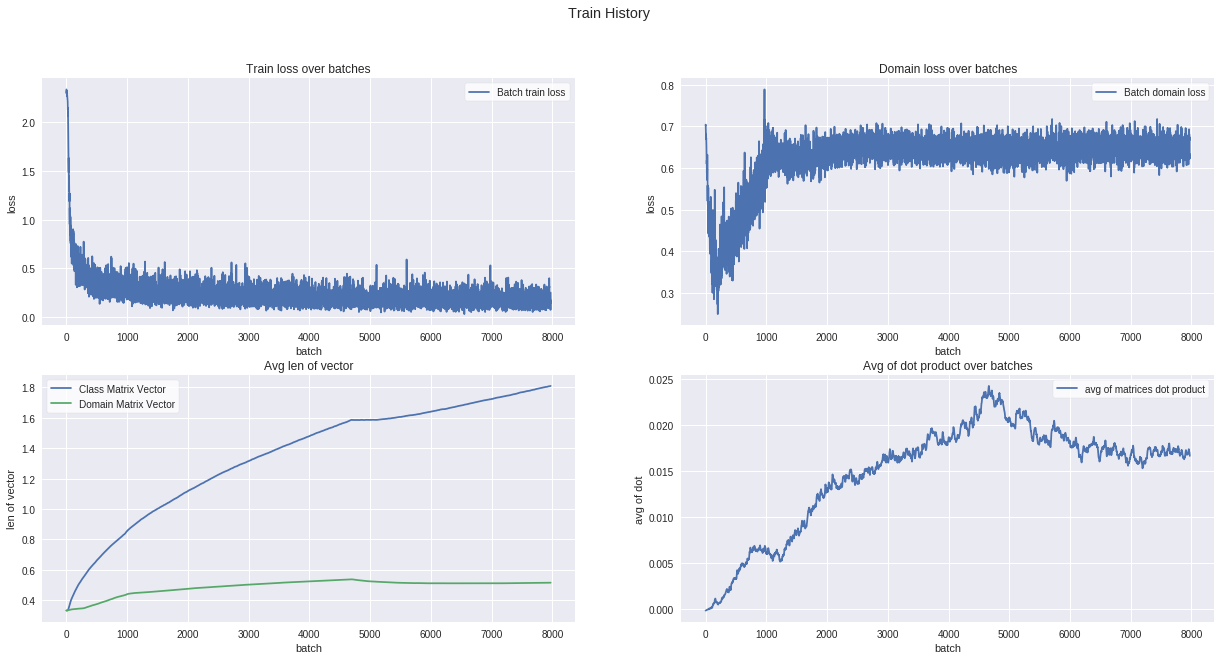

In [39]:
plots.plot_training(trainer_next.train_history)

## Minimize dot product and keeping lengths of class predictor vectors

In [0]:
trainer_next = copy.deepcopy(model_trainer)

In [0]:
def mtx_dot_len(model_c_len):
  def f(*args):
    model_f, model_c, model_d, *args = args
    return torch.mean(torch.pow(torch.mm(model_c.get_mtx().weight, torch.transpose(
        model_d.get_mtx().weight, 0, 1)), 2)) + torch.abs(model_c_len - torch.mean(
        torch.diag(torch.mm(model_c.get_mtx().weight, torch.transpose(
        model_c.get_mtx().weight, 0, 1)))))
  return f

In [42]:
test_history3 = defaultdict(lambda:[])
f = mtx_dot_len(torch.mean(torch.diag(torch.mm(model_c.fc1.weight,
                                               torch.transpose(model_c.fc1.weight, 0, 1)))).item())
trainer_next.train(4, loaders, f, test_history=test_history3)

Train Epoch: 					1 [0/60000 (0%)]	Loss: 0.162079, p: 0.00000 lambd: 0.00000
Train Epoch: 					1 [12800/60000 (21%)]	Loss: 0.194720, p: 0.05333 lambd: 0.26052
Train Epoch: 					1 [25600/60000 (43%)]	Loss: 0.185689, p: 0.10667 lambd: 0.48792
Train Epoch: 					1 [38400/60000 (64%)]	Loss: 0.158465, p: 0.16000 lambd: 0.66404
Train Epoch: 					1 [51200/60000 (85%)]	Loss: 0.180061, p: 0.21333 lambd: 0.78820

Target Domain Test set: Average loss: 0.8510, Accuracy: 7753/10000 (78%)

Source Domain Test set: Average loss: 0.0541, Accuracy: 9830/10000 (98%)

Domains predictor:  Accuracy: 13734/20000 (69%)

Train Epoch: 					2 [0/60000 (0%)]	Loss: 0.152446, p: 0.25000 lambd: 0.84828
Train Epoch: 					2 [12800/60000 (21%)]	Loss: 0.163167, p: 0.30333 lambd: 0.90812
Train Epoch: 					2 [25600/60000 (43%)]	Loss: 0.158142, p: 0.35667 lambd: 0.94505
Train Epoch: 					2 [38400/60000 (64%)]	Loss: 0.170451, p: 0.41000 lambd: 0.96740
Train Epoch: 					2 [51200/60000 (85%)]	Loss: 0.164367, p: 0.46333 lambd: 

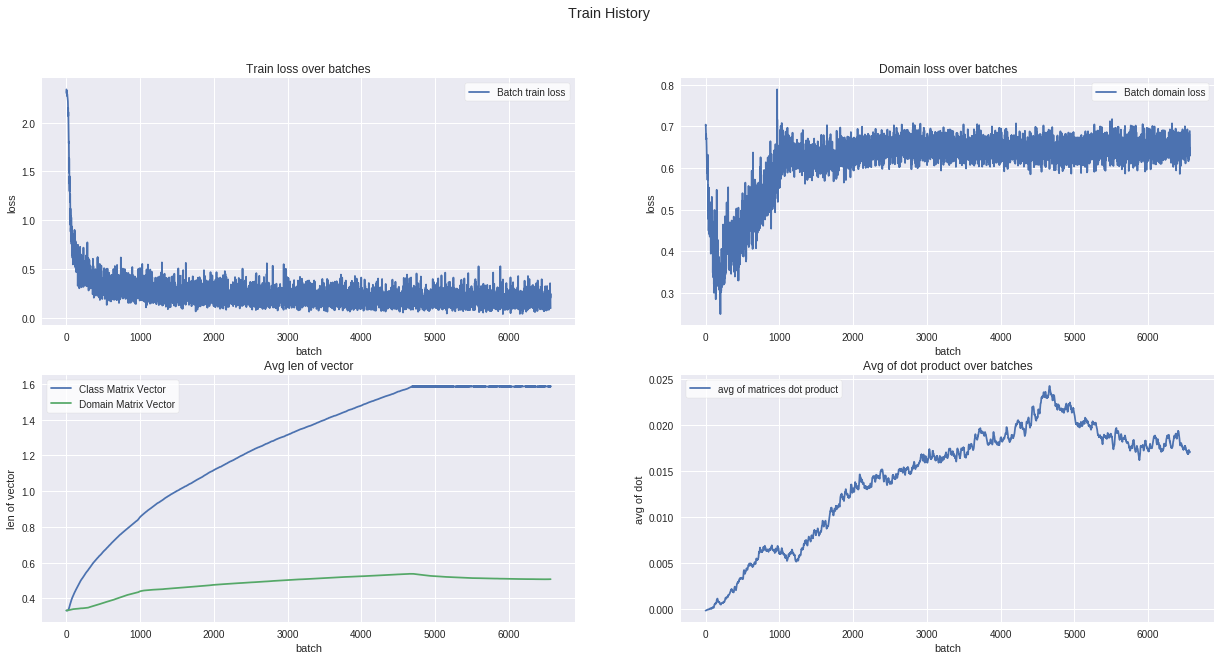

In [43]:
plots.plot_training(trainer_next.train_history)

## Minimize dot product and lengths of class predictor vectors

In [0]:
trainer_next = copy.deepcopy(model_trainer)

In [45]:
test_history4 = defaultdict(lambda:[])
f = mtx_dot_len(0)
trainer_next.train(4, loaders, f, test_history=test_history4)

Train Epoch: 					1 [0/60000 (0%)]	Loss: 1.840223, p: 0.00000 lambd: 0.00000
Train Epoch: 					1 [12800/60000 (21%)]	Loss: 0.541364, p: 0.05333 lambd: 0.26052
Train Epoch: 					1 [25600/60000 (43%)]	Loss: 0.470737, p: 0.10667 lambd: 0.48792
Train Epoch: 					1 [38400/60000 (64%)]	Loss: 0.273090, p: 0.16000 lambd: 0.66404
Train Epoch: 					1 [51200/60000 (85%)]	Loss: 0.421939, p: 0.21333 lambd: 0.78820

Target Domain Test set: Average loss: 0.7793, Accuracy: 7694/10000 (77%)

Source Domain Test set: Average loss: 0.0802, Accuracy: 9758/10000 (98%)

Domains predictor:  Accuracy: 14789/20000 (74%)

Train Epoch: 					2 [0/60000 (0%)]	Loss: 0.293563, p: 0.25000 lambd: 0.84828
Train Epoch: 					2 [12800/60000 (21%)]	Loss: 0.374838, p: 0.30333 lambd: 0.90812
Train Epoch: 					2 [25600/60000 (43%)]	Loss: 0.398544, p: 0.35667 lambd: 0.94505
Train Epoch: 					2 [38400/60000 (64%)]	Loss: 0.319352, p: 0.41000 lambd: 0.96740
Train Epoch: 					2 [51200/60000 (85%)]	Loss: 0.381381, p: 0.46333 lambd: 

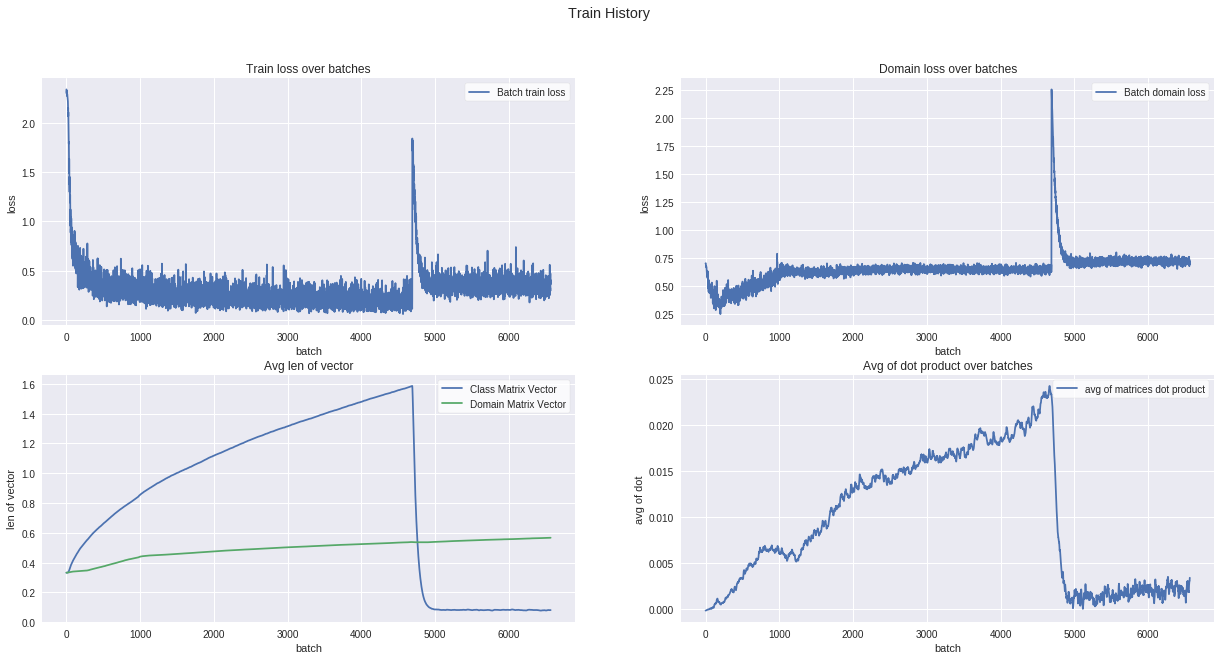

In [46]:
plots.plot_training(trainer_next.train_history)

## Minimize dot product and lengths of predictors' vectors

In [0]:
trainer_next = copy.deepcopy(model_trainer)

In [0]:
def mtx_dot_lens(model_c_len, model_d_len):
  def f(*args):
    model_f, model_c, model_d, *args = args
    return torch.mean(torch.pow(torch.mm(model_c.get_mtx().weight, torch.transpose(
        model_d.get_mtx().weight, 0, 1)), 2)) + torch.abs(model_c_len - torch.mean(
        torch.diag(torch.mm(model_c.get_mtx().weight, torch.transpose(
        model_c.get_mtx().weight, 0, 1))))) + torch.abs(model_d_len - torch.mean(
        torch.diag(torch.mm(model_d.get_mtx().weight, torch.transpose(
        model_d.get_mtx().weight, 0, 1)))))
  return f

In [49]:
test_history5 = defaultdict(lambda:[])
f = mtx_dot_lens(0, 0)
trainer_next.train(4, loaders, f, test_history=test_history5)

Train Epoch: 					1 [0/60000 (0%)]	Loss: 2.244505, p: 0.00000 lambd: 0.00000
Train Epoch: 					1 [12800/60000 (21%)]	Loss: 0.807193, p: 0.05333 lambd: 0.26052
Train Epoch: 					1 [25600/60000 (43%)]	Loss: 0.400737, p: 0.10667 lambd: 0.48792
Train Epoch: 					1 [38400/60000 (64%)]	Loss: 0.459303, p: 0.16000 lambd: 0.66404
Train Epoch: 					1 [51200/60000 (85%)]	Loss: 0.458478, p: 0.21333 lambd: 0.78820

Target Domain Test set: Average loss: 0.7923, Accuracy: 7678/10000 (77%)

Source Domain Test set: Average loss: 0.0827, Accuracy: 9724/10000 (97%)

Domains predictor:  Accuracy: 13982/20000 (70%)

Train Epoch: 					2 [0/60000 (0%)]	Loss: 0.415905, p: 0.25000 lambd: 0.84828
Train Epoch: 					2 [12800/60000 (21%)]	Loss: 0.317145, p: 0.30333 lambd: 0.90812
Train Epoch: 					2 [25600/60000 (43%)]	Loss: 0.372751, p: 0.35667 lambd: 0.94505
Train Epoch: 					2 [38400/60000 (64%)]	Loss: 0.359546, p: 0.41000 lambd: 0.96740
Train Epoch: 					2 [51200/60000 (85%)]	Loss: 0.410821, p: 0.46333 lambd: 

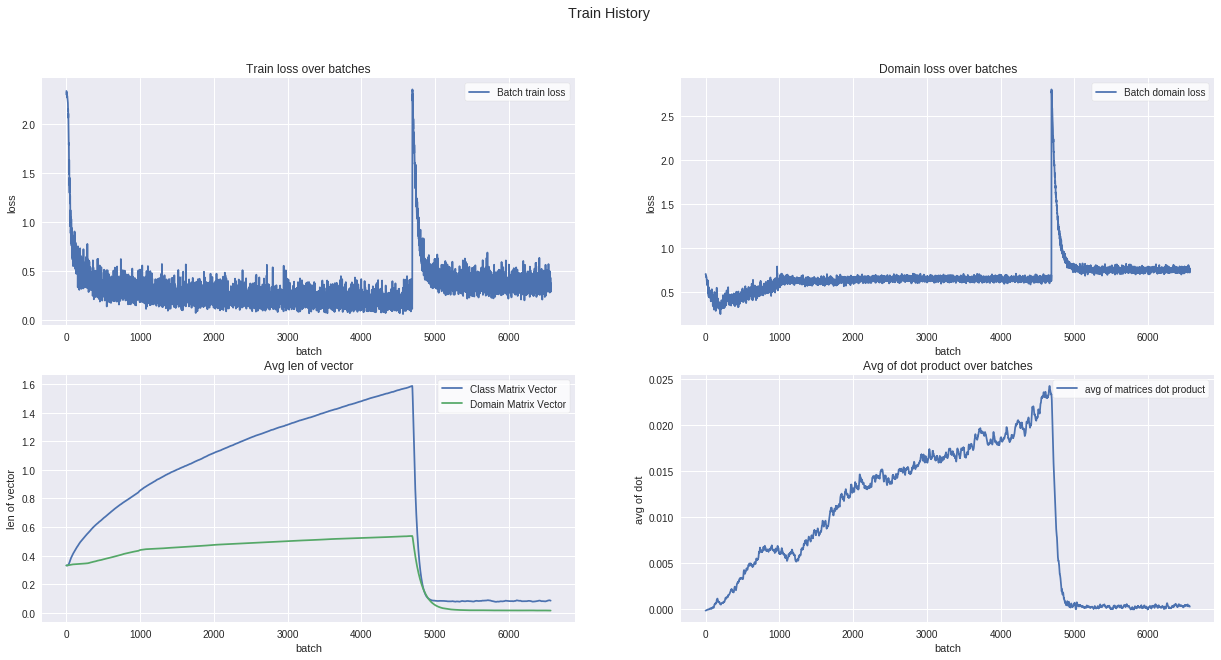

In [50]:
plots.plot_training(trainer_next.train_history)

# Adam Optimizer

In [0]:
model_f_adam = models.MnistFeatureExtractor().to(device)
model_c_adam = models.MnistClassPredictor().to(device)
model_d_adam = models.MnistDomain().to(device)
lr=0.001
adam_f = optim.Adam(model_f_adam.parameters(), lr=lr)
adam_c = optim.Adam(model_c_adam.parameters(), lr=lr)
adam_d = optim.Adam(model_d_adam.parameters(), lr=lr)

adam_models = Models(model_f_adam, model_c_adam, model_d_adam)
adam_optims = Optims(adam_f, adam_c, adam_d)

In [0]:
adam_trainer = trainer.Trainer(adam_models, adam_optims, criterions, device)

In [53]:
adam_test_history = defaultdict(lambda:[])
adam_trainer.train(epochs, loaders, test_history=adam_test_history)

Train Epoch: 					1 [0/60000 (0%)]	Loss: 2.303483, p: 0.00000 lambd: 0.00000
Train Epoch: 					1 [12800/60000 (21%)]	Loss: 0.343203, p: 0.02133 lambd: 0.10626
Train Epoch: 					1 [25600/60000 (43%)]	Loss: 0.360309, p: 0.04267 lambd: 0.21015
Train Epoch: 					1 [38400/60000 (64%)]	Loss: 0.278073, p: 0.06400 lambd: 0.30951
Train Epoch: 					1 [51200/60000 (85%)]	Loss: 0.271725, p: 0.08533 lambd: 0.40253

Target Domain Test set: Average loss: 1.3503, Accuracy: 5970/10000 (60%)

Source Domain Test set: Average loss: 0.0901, Accuracy: 9712/10000 (97%)

Domains predictor:  Accuracy: 17383/20000 (87%)

Train Epoch: 					2 [0/60000 (0%)]	Loss: 0.280872, p: 0.10000 lambd: 0.46212
Train Epoch: 					2 [12800/60000 (21%)]	Loss: 0.239424, p: 0.12133 lambd: 0.54178
Train Epoch: 					2 [25600/60000 (43%)]	Loss: 0.250971, p: 0.14267 lambd: 0.61276
Train Epoch: 					2 [38400/60000 (64%)]	Loss: 0.269861, p: 0.16400 lambd: 0.67507
Train Epoch: 					2 [51200/60000 (85%)]	Loss: 0.273083, p: 0.18533 lambd: 

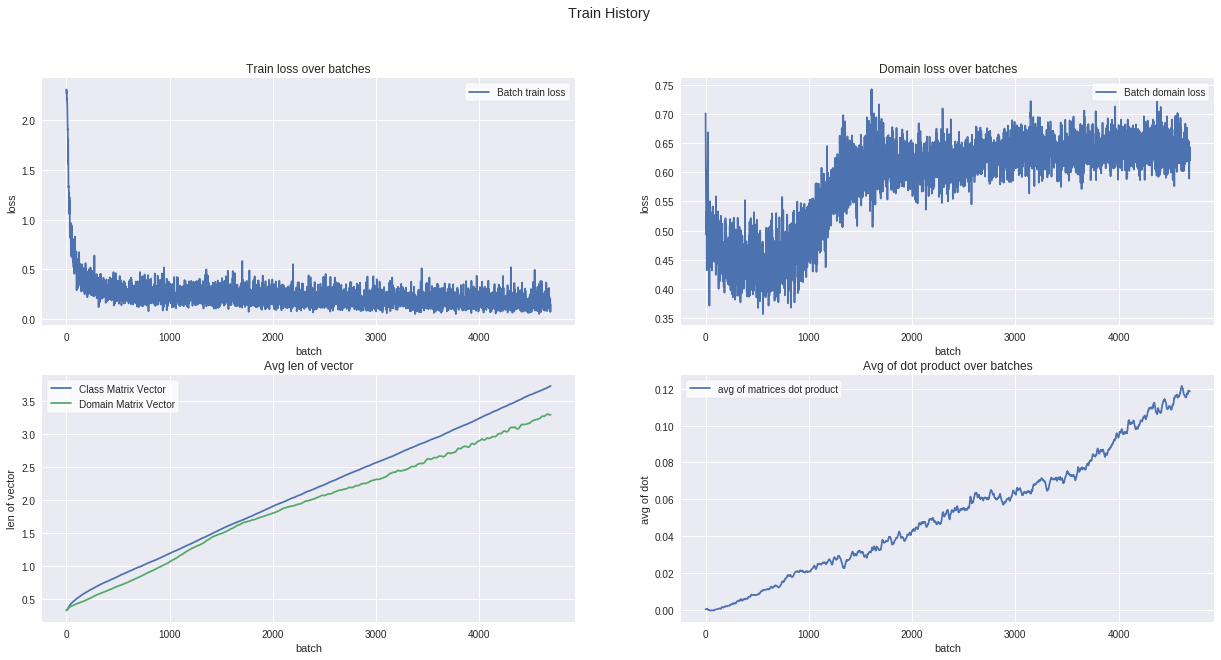

In [54]:
plots.plot_training(adam_trainer.train_history)

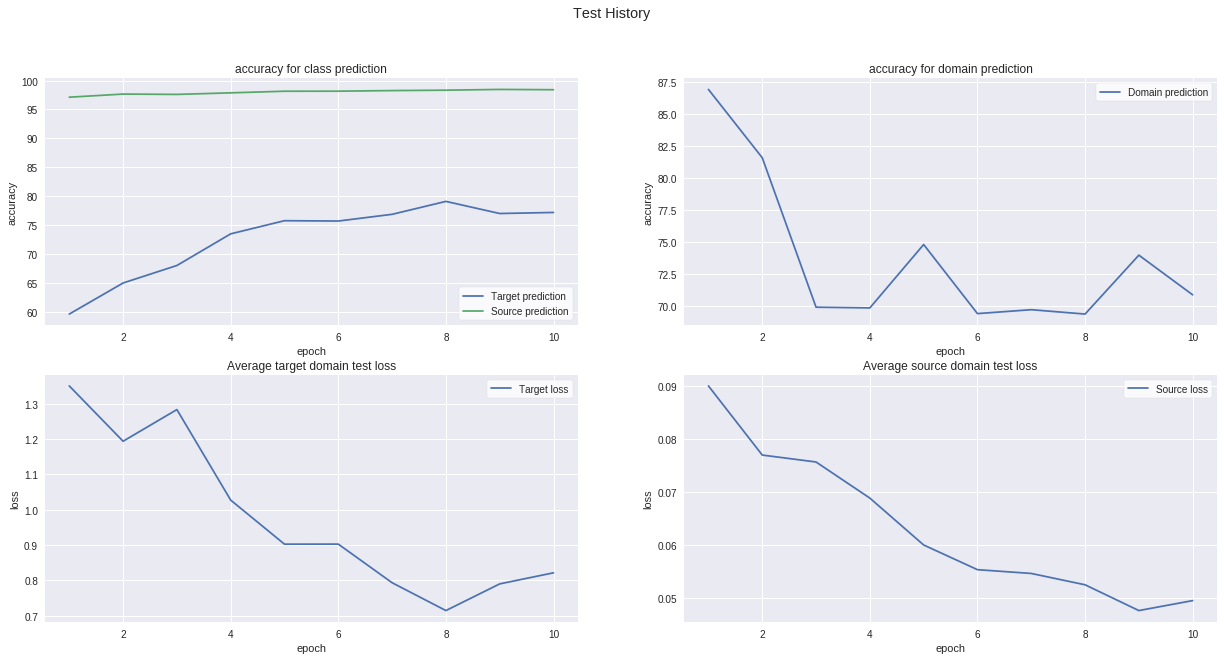

In [55]:
plots.plot_test(adam_test_history)

## Adam Optimizer with minimization of dot product

In [0]:
adam_trainer_next = copy.deepcopy(adam_trainer)

In [57]:
adam_test_history2 = defaultdict(lambda:[])
adam_trainer_next.train(8, loaders, mtx_dot, test_history=adam_test_history2)

Train Epoch: 					1 [0/60000 (0%)]	Loss: 0.328515, p: 0.00000 lambd: 0.00000
Train Epoch: 					1 [12800/60000 (21%)]	Loss: 0.139656, p: 0.02667 lambd: 0.13255
Train Epoch: 					1 [25600/60000 (43%)]	Loss: 0.178551, p: 0.05333 lambd: 0.26052
Train Epoch: 					1 [38400/60000 (64%)]	Loss: 0.149842, p: 0.08000 lambd: 0.37995
Train Epoch: 					1 [51200/60000 (85%)]	Loss: 0.193036, p: 0.10667 lambd: 0.48792

Target Domain Test set: Average loss: 0.8221, Accuracy: 7700/10000 (77%)

Source Domain Test set: Average loss: 0.0436, Accuracy: 9855/10000 (99%)

Domains predictor:  Accuracy: 13292/20000 (66%)

Train Epoch: 					2 [0/60000 (0%)]	Loss: 0.311431, p: 0.12500 lambd: 0.55460
Train Epoch: 					2 [12800/60000 (21%)]	Loss: 0.151913, p: 0.15167 lambd: 0.64009
Train Epoch: 					2 [25600/60000 (43%)]	Loss: 0.083151, p: 0.17833 lambd: 0.71222
Train Epoch: 					2 [38400/60000 (64%)]	Loss: 0.157120, p: 0.20500 lambd: 0.77190
Train Epoch: 					2 [51200/60000 (85%)]	Loss: 0.141929, p: 0.23167 lambd: 

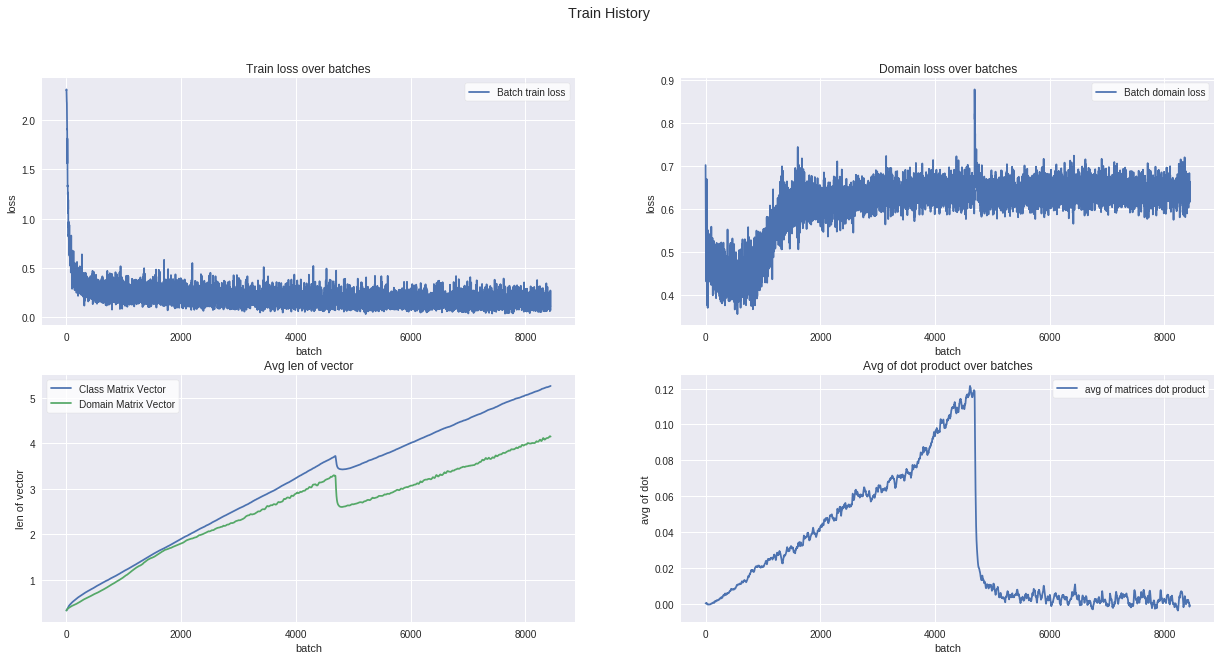

In [58]:
plots.plot_training(adam_trainer_next.train_history)

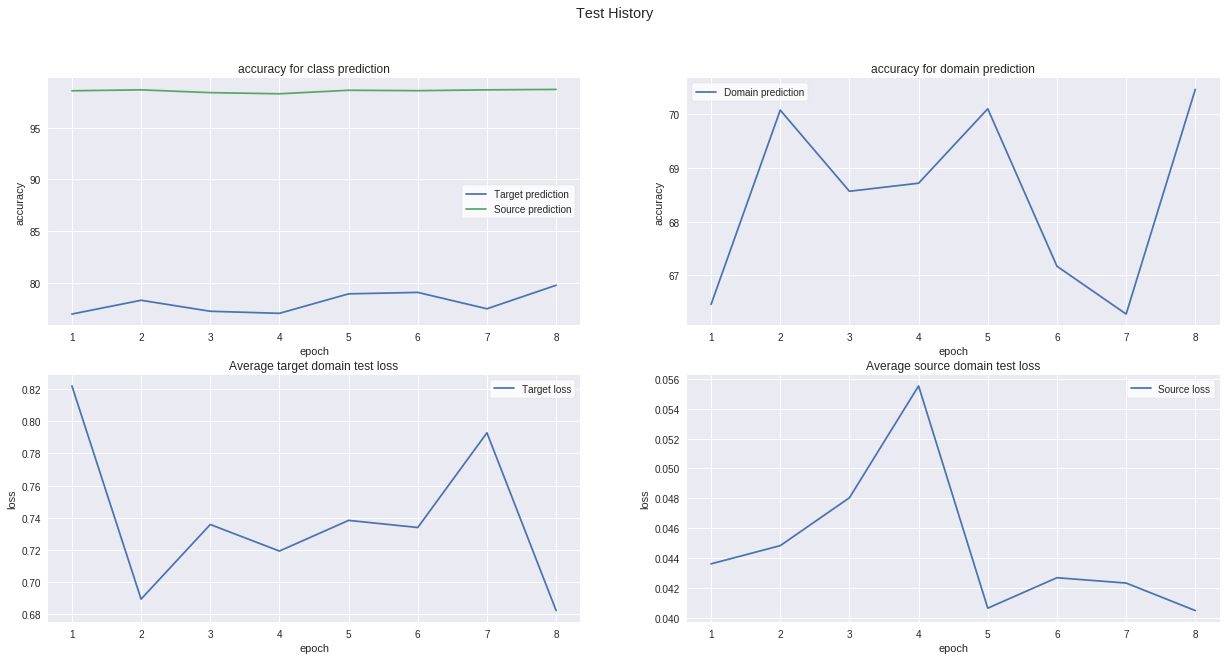

In [59]:
plots.plot_test(adam_test_history2)

# Adding GR to pretrained domain predictor

In [0]:
lr=0.01
new_gr_model = models.MnistDomain()
new_gr_model.load_state_dict(domain_pred.state_dict())
new_gr_model = new_gr_model.to(device)
new_optim_d = optim.SGD(new_gr_model.parameters(), lr=lr, momentum=momentum)

In [61]:
dom_pr = nn.Sequential(model_f, new_gr_model)
domain_trainer.DomainTrainer.test_domain_pred(dom_pr, device, mnist_ext_test_loader)


Domains predictor:  Accuracy: 18453/20000 (92%)



In [0]:
new_domain_train_models = Models(model_f, model_c, new_gr_model)
new_domain_train_optims = Optims(optim_f, optim_c, new_optim_d)

In [0]:
domain_trainer_next = trainer.Trainer(new_domain_train_models, new_domain_train_optims, criterions, device)

In [64]:
test_history6 = defaultdict(lambda:[])
domain_trainer_next.train(5, loaders, test_history=test_history6)

Train Epoch: 					1 [0/60000 (0%)]	Loss: 0.224304, p: 0.00000 lambd: 0.00000
Train Epoch: 					1 [12800/60000 (21%)]	Loss: 0.125879, p: 0.04267 lambd: 0.21015
Train Epoch: 					1 [25600/60000 (43%)]	Loss: 0.072794, p: 0.08533 lambd: 0.40253
Train Epoch: 					1 [38400/60000 (64%)]	Loss: 0.177543, p: 0.12800 lambd: 0.56490
Train Epoch: 					1 [51200/60000 (85%)]	Loss: 0.116203, p: 0.17067 lambd: 0.69281

Target Domain Test set: Average loss: 0.9389, Accuracy: 7718/10000 (77%)

Source Domain Test set: Average loss: 0.0577, Accuracy: 9811/10000 (98%)

Domains predictor:  Accuracy: 13180/20000 (66%)

Train Epoch: 					2 [0/60000 (0%)]	Loss: 0.174476, p: 0.20000 lambd: 0.76159
Train Epoch: 					2 [12800/60000 (21%)]	Loss: 0.110750, p: 0.24267 lambd: 0.83768
Train Epoch: 					2 [25600/60000 (43%)]	Loss: 0.189998, p: 0.28533 lambd: 0.89098
Train Epoch: 					2 [38400/60000 (64%)]	Loss: 0.239792, p: 0.32800 lambd: 0.92747
Train Epoch: 					2 [51200/60000 (85%)]	Loss: 0.187952, p: 0.37067 lambd: 

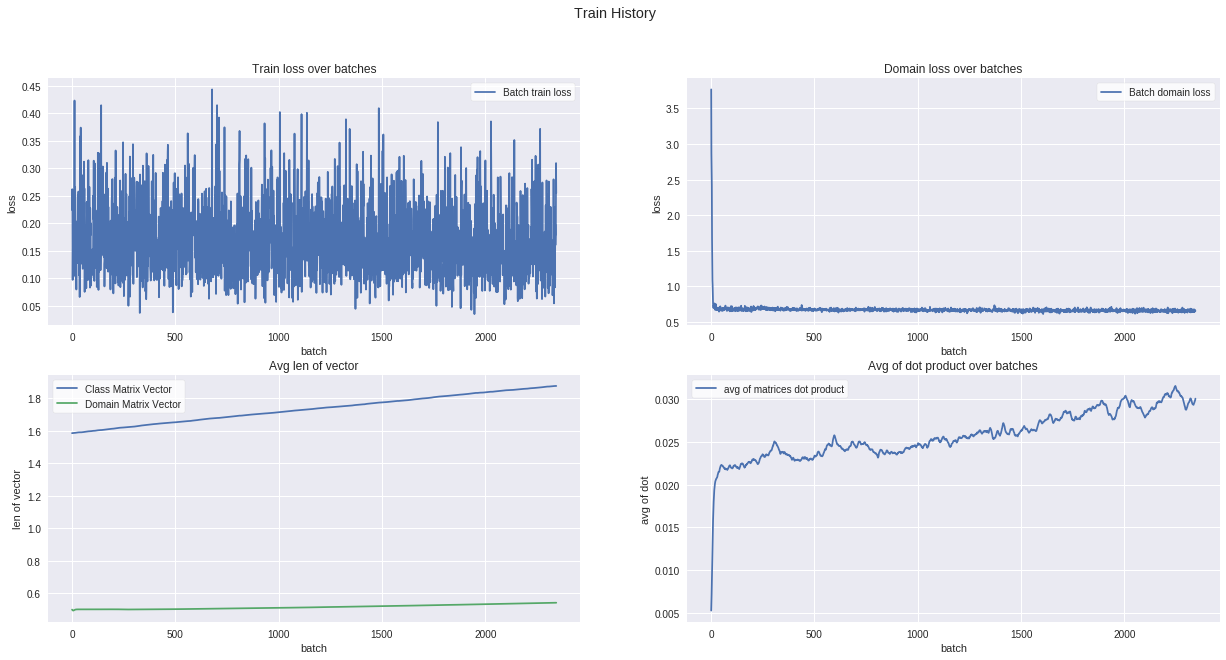

In [65]:
plots.plot_training(domain_trainer_next.train_history)

In [66]:
#new feature extractor, old domain predictor
dom_pr = nn.Sequential(new_domain_train_models.model_f, domain_pred)
domain_trainer.DomainTrainer.test_domain_pred(dom_pr, device, mnist_ext_test_loader)


Domains predictor:  Accuracy: 9839/20000 (49%)



In [67]:
#new feature extractor, new domain predictor
dom_pr = nn.Sequential(new_domain_train_models.model_f, new_gr_model)
domain_trainer.DomainTrainer.test_domain_pred(dom_pr, device, mnist_ext_test_loader)


Domains predictor:  Accuracy: 13955/20000 (70%)



## Getting new domain predictor

In [0]:
domain_pred = models.DomainPredictor().to(device)
domain_optim = optim.SGD(domain_pred.parameters(), lr=lr, momentum=momentum)

In [0]:
models_dom = Models(new_domain_train_models.model_f, None, domain_pred)
optims_dom = Optims(None, None, optim_d=domain_optim)
mnist_domain_trainer = domain_trainer.DomainTrainer(models_dom, optims_dom, criterions, device)

In [70]:
domain_train_history = defaultdict(lambda:[])
mnist_domain_trainer.train(4, loaders, train_models, train_history=domain_train_history)

Train Epoch: 1 [0/20000 (0%)]	Loss: 0.746763

Domains predictor:  Accuracy: 16733/20000 (84%)

Train Epoch: 2 [0/20000 (0%)]	Loss: 0.453666

Domains predictor:  Accuracy: 17359/20000 (87%)

Train Epoch: 3 [0/20000 (0%)]	Loss: 0.414115

Domains predictor:  Accuracy: 17955/20000 (90%)

Train Epoch: 4 [0/20000 (0%)]	Loss: 0.315618

Domains predictor:  Accuracy: 18170/20000 (91%)



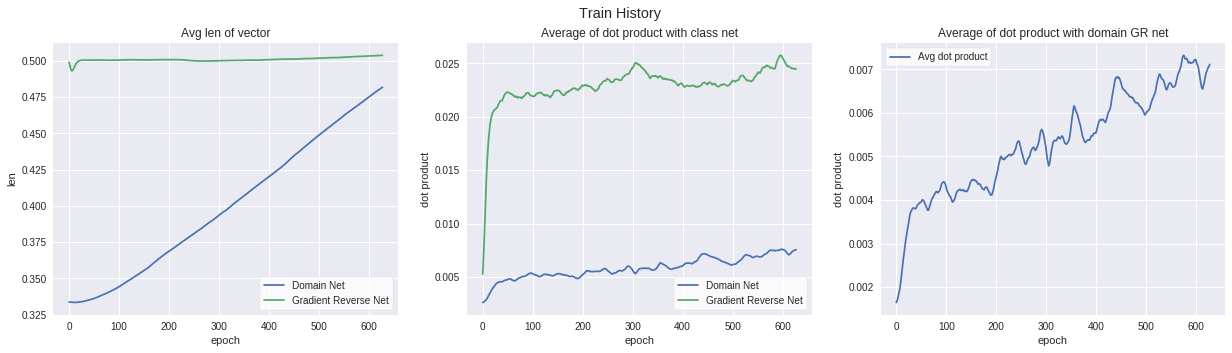

In [71]:
plots.plot_domain_training(domain_train_history, domain_trainer_next.train_history)

# Tests results

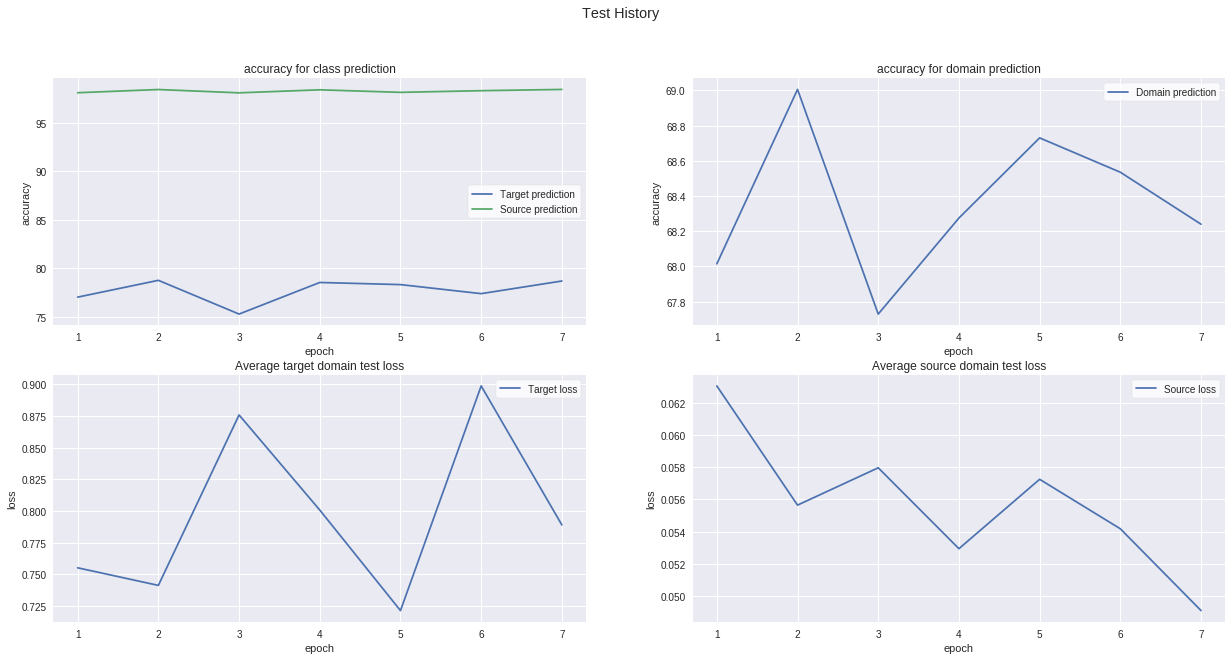

In [73]:
plots.plot_test(test_history2)

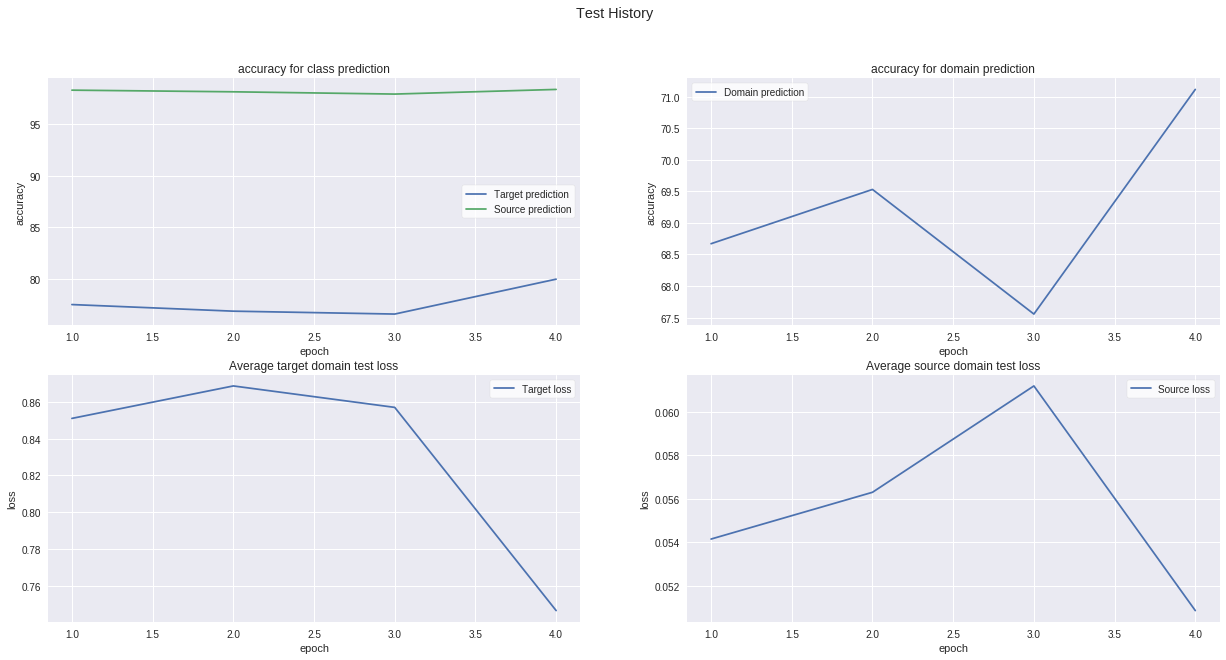

In [74]:
plots.plot_test(test_history3)

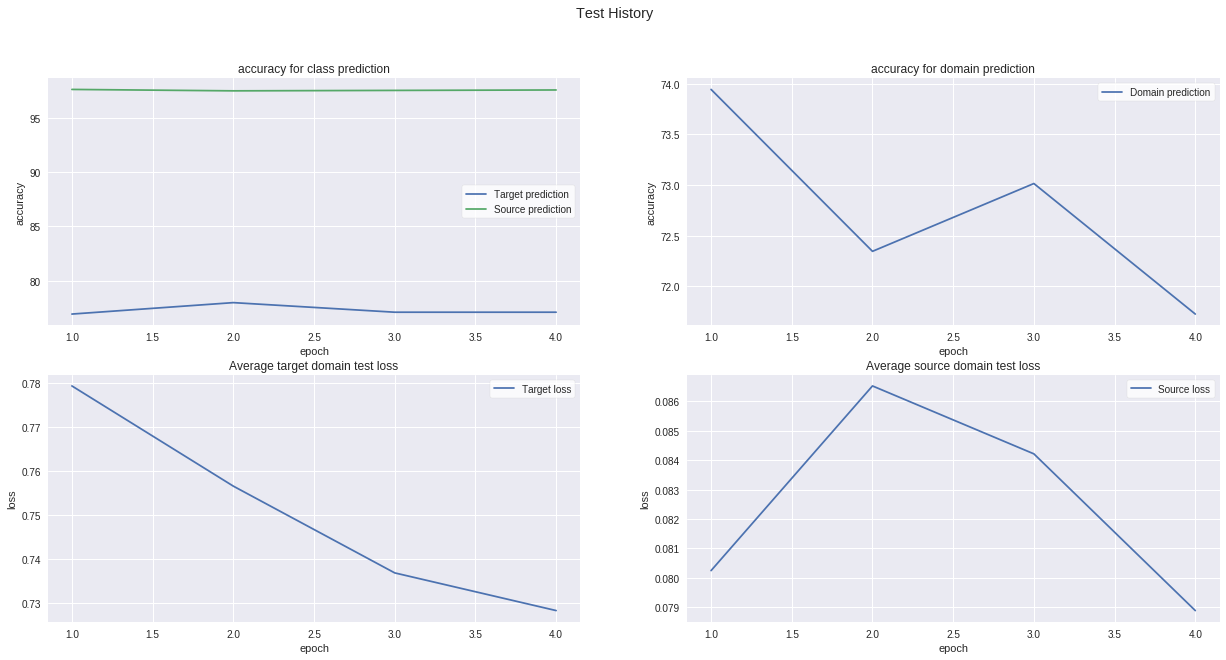

In [75]:
plots.plot_test(test_history4)

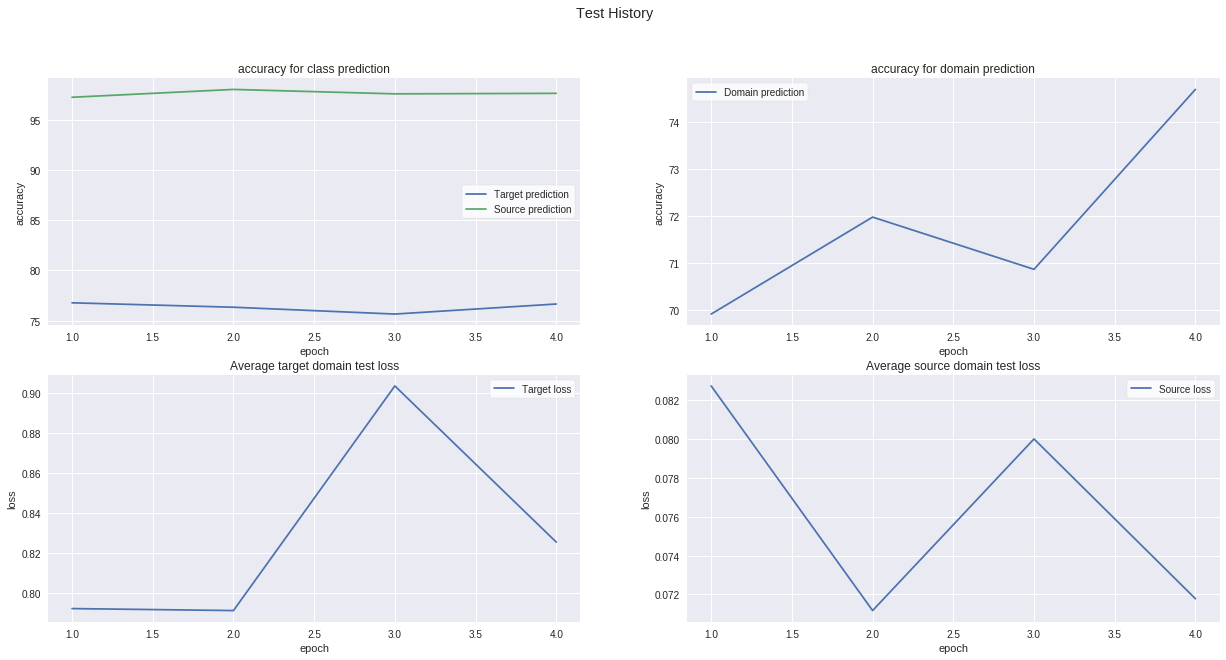

In [76]:
plots.plot_test(test_history5)

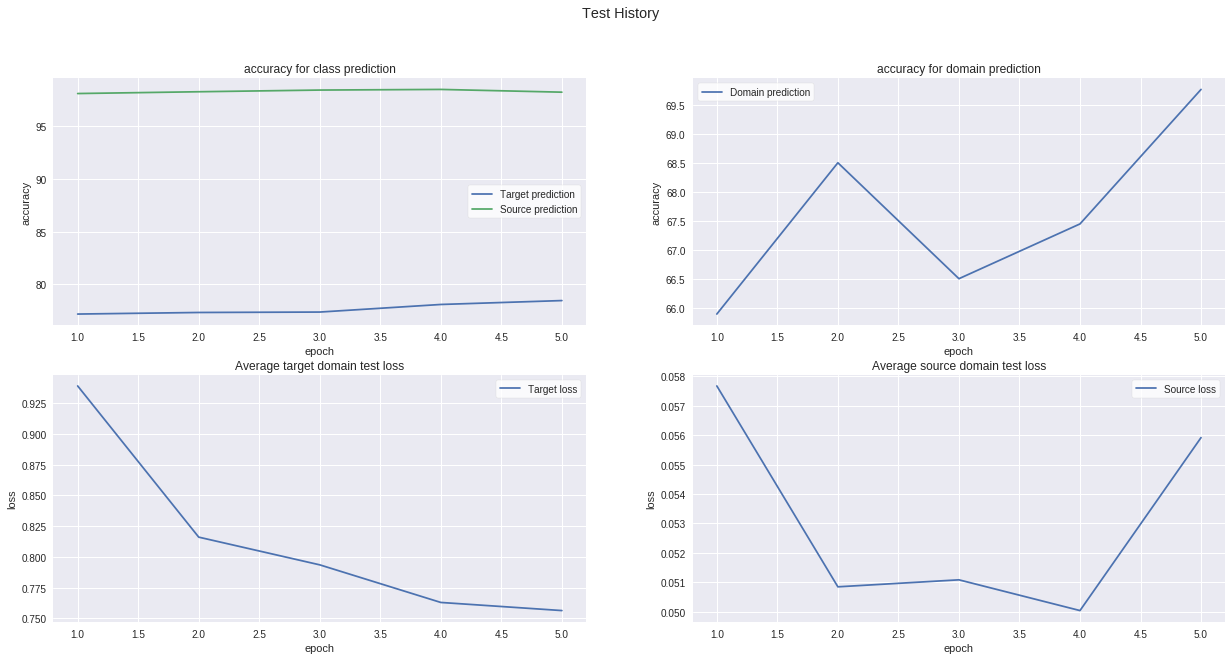

In [77]:
plots.plot_test(test_history6)

# Increasing lambda factor after first training

In [0]:
lr = 0.001

In [0]:
model_f = models.MnistFeatureExtractor().to(device)
model_c = models.MnistClassPredictor().to(device)
model_d = models.MnistDomain().to(device)
optim_f = optim.Adam(model_f.parameters(), lr=lr)
optim_c = optim.Adam(model_c.parameters(), lr=lr)
optim_d = optim.Adam(model_d.parameters(), lr=lr)

train_models = Models(model_f, model_c, model_d)
optims = Optims(optim_f, optim_c, optim_d)

In [0]:
model_trainer = trainer.Trainer(train_models, optims, criterions, device)

In [166]:
test_history = defaultdict(lambda:[])
model_trainer.train(epochs, loaders, test_history=test_history)

Train Epoch: 					1 [0/60000 (0%)]	Loss: 2.335161, lr: 0.00000 lambd: 0.00000
Train Epoch: 					1 [12800/60000 (21%)]	Loss: 0.528654, lr: 0.00000 lambd: 0.10626
Train Epoch: 					1 [25600/60000 (43%)]	Loss: 0.309885, lr: 0.00000 lambd: 0.21015
Train Epoch: 					1 [38400/60000 (64%)]	Loss: 0.217060, lr: 0.00000 lambd: 0.30951
Train Epoch: 					1 [51200/60000 (85%)]	Loss: 0.208058, lr: 0.00000 lambd: 0.40253

Target Domain Test set: Average loss: 1.2457, Accuracy: 6212/10000 (62%)

Source Domain Test set: Average loss: 0.0943, Accuracy: 9720/10000 (97%)

Domains predictor:  Accuracy: 17659/20000 (88%)

Train Epoch: 					2 [0/60000 (0%)]	Loss: 0.492564, lr: 0.00000 lambd: 0.46212
Train Epoch: 					2 [12800/60000 (21%)]	Loss: 0.220410, lr: 0.00000 lambd: 0.54178
Train Epoch: 					2 [25600/60000 (43%)]	Loss: 0.200028, lr: 0.00000 lambd: 0.61276
Train Epoch: 					2 [38400/60000 (64%)]	Loss: 0.248037, lr: 0.00000 lambd: 0.67507
Train Epoch: 					2 [51200/60000 (85%)]	Loss: 0.187527, lr: 0.000

In [0]:
trainer_next = copy.deepcopy(model_trainer)

In [0]:
trainer_next.default_lambd = 3.0
trainer_next.use_lambd = False

In [175]:
test_history_next = defaultdict(lambda:[])
trainer_next.train(epochs, loaders, test_history=test_history_next)

Train Epoch: 					1 [0/60000 (0%)]	Loss: 0.176099, lr: 0.00000 lambd: 3.00000
Train Epoch: 					1 [12800/60000 (21%)]	Loss: 0.291919, lr: 0.00000 lambd: 3.00000
Train Epoch: 					1 [25600/60000 (43%)]	Loss: 0.138833, lr: 0.00000 lambd: 3.00000
Train Epoch: 					1 [38400/60000 (64%)]	Loss: 0.316165, lr: 0.00000 lambd: 3.00000
Train Epoch: 					1 [51200/60000 (85%)]	Loss: 0.128789, lr: 0.00000 lambd: 3.00000

Target Domain Test set: Average loss: 0.8632, Accuracy: 7742/10000 (77%)

Source Domain Test set: Average loss: 0.0624, Accuracy: 9810/10000 (98%)

Domains predictor:  Accuracy: 13795/20000 (69%)

Train Epoch: 					2 [0/60000 (0%)]	Loss: 0.300487, lr: 0.00000 lambd: 3.00000
Train Epoch: 					2 [12800/60000 (21%)]	Loss: 0.264764, lr: 0.00000 lambd: 3.00000
Train Epoch: 					2 [25600/60000 (43%)]	Loss: 0.281720, lr: 0.00000 lambd: 3.00000
Train Epoch: 					2 [38400/60000 (64%)]	Loss: 0.208725, lr: 0.00000 lambd: 3.00000
Train Epoch: 					2 [51200/60000 (85%)]	Loss: 0.202837, lr: 0.000

In [0]:
trainer_next2 = copy.deepcopy(model_trainer)

In [177]:
test_history_next2 = defaultdict(lambda:[])
trainer_next2.train(epochs, loaders, test_history=test_history_next2)

Train Epoch: 					1 [0/60000 (0%)]	Loss: 0.233965, lr: 0.00000 lambd: 0.00000
Train Epoch: 					1 [12800/60000 (21%)]	Loss: 0.153965, lr: 0.00000 lambd: 0.10626
Train Epoch: 					1 [25600/60000 (43%)]	Loss: 0.190539, lr: 0.00000 lambd: 0.21015
Train Epoch: 					1 [38400/60000 (64%)]	Loss: 0.130887, lr: 0.00000 lambd: 0.30951
Train Epoch: 					1 [51200/60000 (85%)]	Loss: 0.184581, lr: 0.00000 lambd: 0.40253

Target Domain Test set: Average loss: 0.6991, Accuracy: 7979/10000 (80%)

Source Domain Test set: Average loss: 0.0469, Accuracy: 9856/10000 (99%)

Domains predictor:  Accuracy: 14742/20000 (74%)

Train Epoch: 					2 [0/60000 (0%)]	Loss: 0.156389, lr: 0.00000 lambd: 0.46212
Train Epoch: 					2 [12800/60000 (21%)]	Loss: 0.120531, lr: 0.00000 lambd: 0.54178
Train Epoch: 					2 [25600/60000 (43%)]	Loss: 0.106443, lr: 0.00000 lambd: 0.61276
Train Epoch: 					2 [38400/60000 (64%)]	Loss: 0.213750, lr: 0.00000 lambd: 0.67507
Train Epoch: 					2 [51200/60000 (85%)]	Loss: 0.054849, lr: 0.000

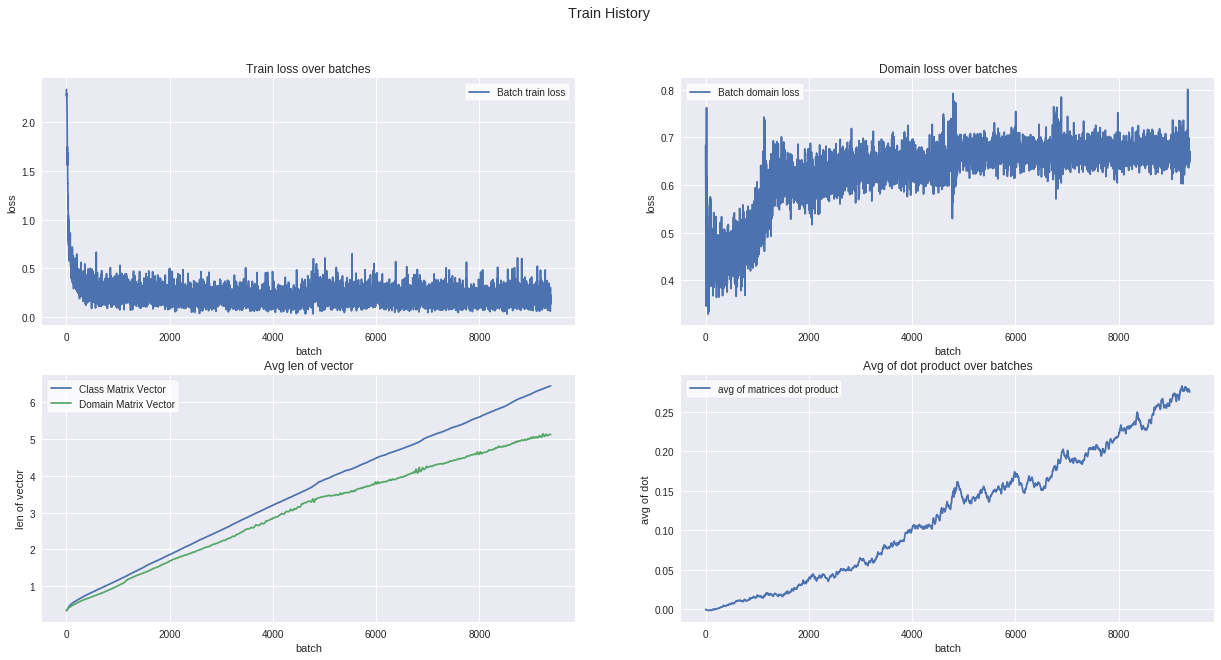

In [178]:
plots.plot_training(trainer_next.train_history)

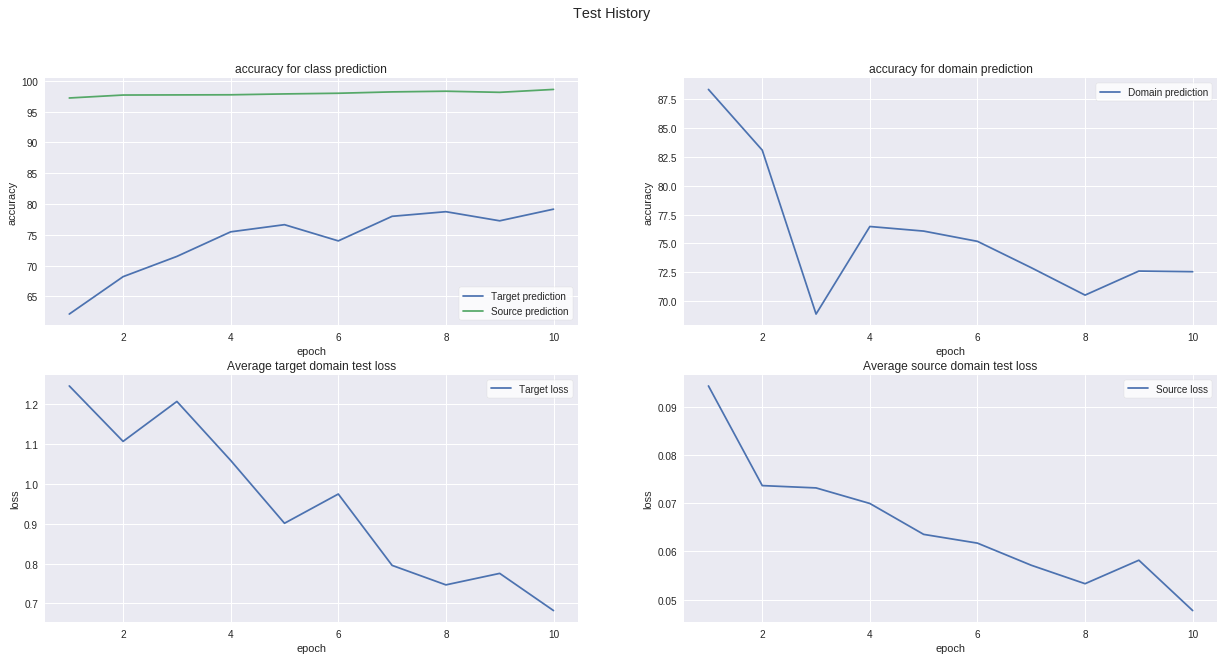

In [179]:
plots.plot_test(test_history)

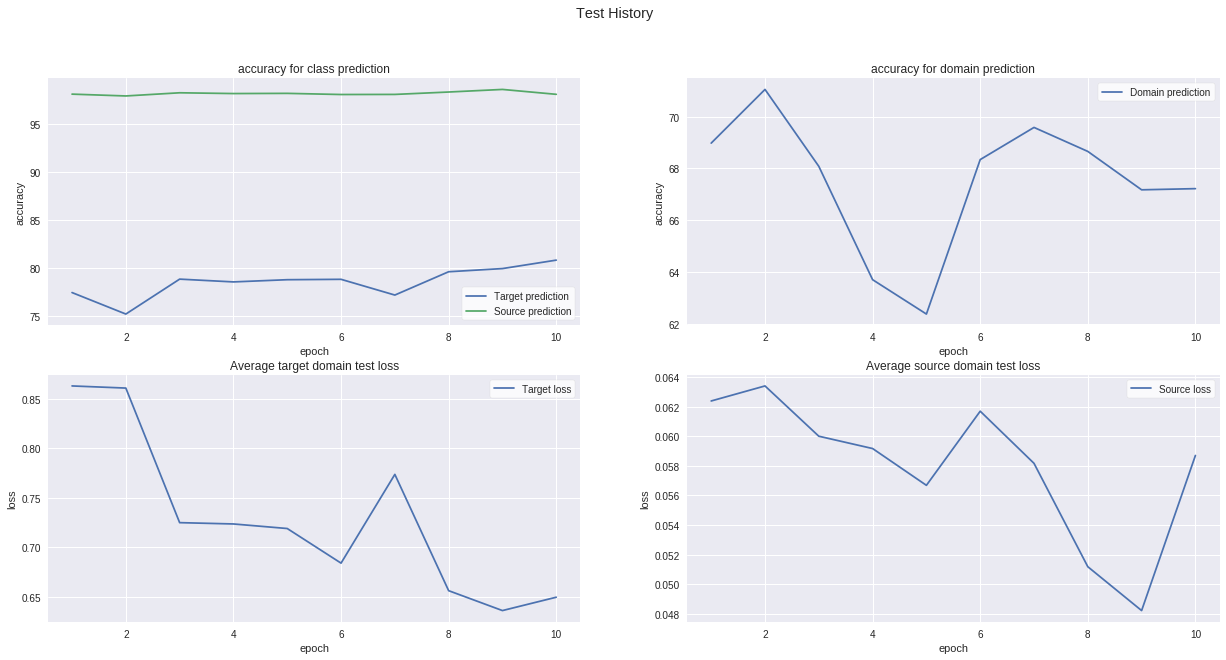

In [180]:
plots.plot_test(test_history_next)

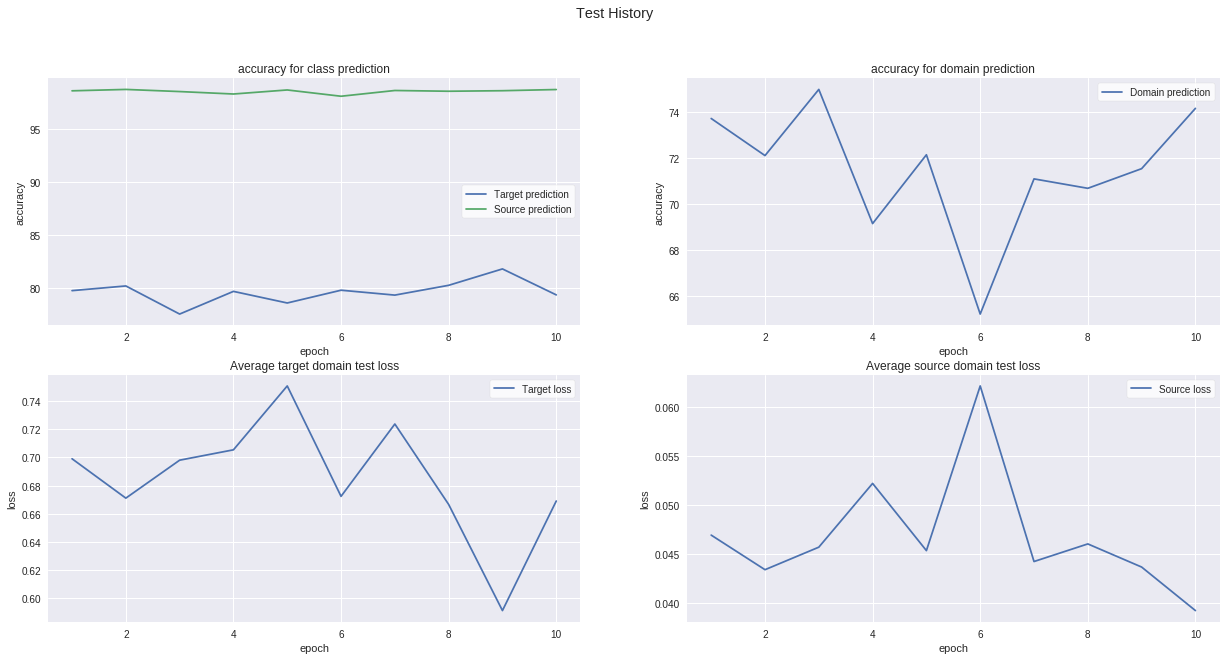

In [181]:
plots.plot_test(test_history_next2)

## Too large factor

In [0]:
trainer_next = copy.deepcopy(model_trainer)

In [0]:
trainer_next.default_lambd = 6.0
trainer_next.use_lambd = False

In [184]:
test_history_next = defaultdict(lambda:[])
trainer_next.train(epochs, loaders, test_history=test_history_next)

Train Epoch: 					1 [0/60000 (0%)]	Loss: 0.168640, lr: 0.00000 lambd: 6.00000
Train Epoch: 					1 [12800/60000 (21%)]	Loss: 0.537747, lr: 0.00000 lambd: 6.00000
Train Epoch: 					1 [25600/60000 (43%)]	Loss: 0.625970, lr: 0.00000 lambd: 6.00000
Train Epoch: 					1 [38400/60000 (64%)]	Loss: 0.190948, lr: 0.00000 lambd: 6.00000
Train Epoch: 					1 [51200/60000 (85%)]	Loss: 0.336515, lr: 0.00000 lambd: 6.00000

Target Domain Test set: Average loss: 0.8485, Accuracy: 7301/10000 (73%)

Source Domain Test set: Average loss: 0.0824, Accuracy: 9730/10000 (97%)

Domains predictor:  Accuracy: 12980/20000 (65%)

Train Epoch: 					2 [0/60000 (0%)]	Loss: 0.224205, lr: 0.00000 lambd: 6.00000
Train Epoch: 					2 [12800/60000 (21%)]	Loss: 0.311929, lr: 0.00000 lambd: 6.00000
Train Epoch: 					2 [25600/60000 (43%)]	Loss: 0.169160, lr: 0.00000 lambd: 6.00000
Train Epoch: 					2 [38400/60000 (64%)]	Loss: 0.138533, lr: 0.00000 lambd: 6.00000
Train Epoch: 					2 [51200/60000 (85%)]	Loss: 0.262223, lr: 0.000

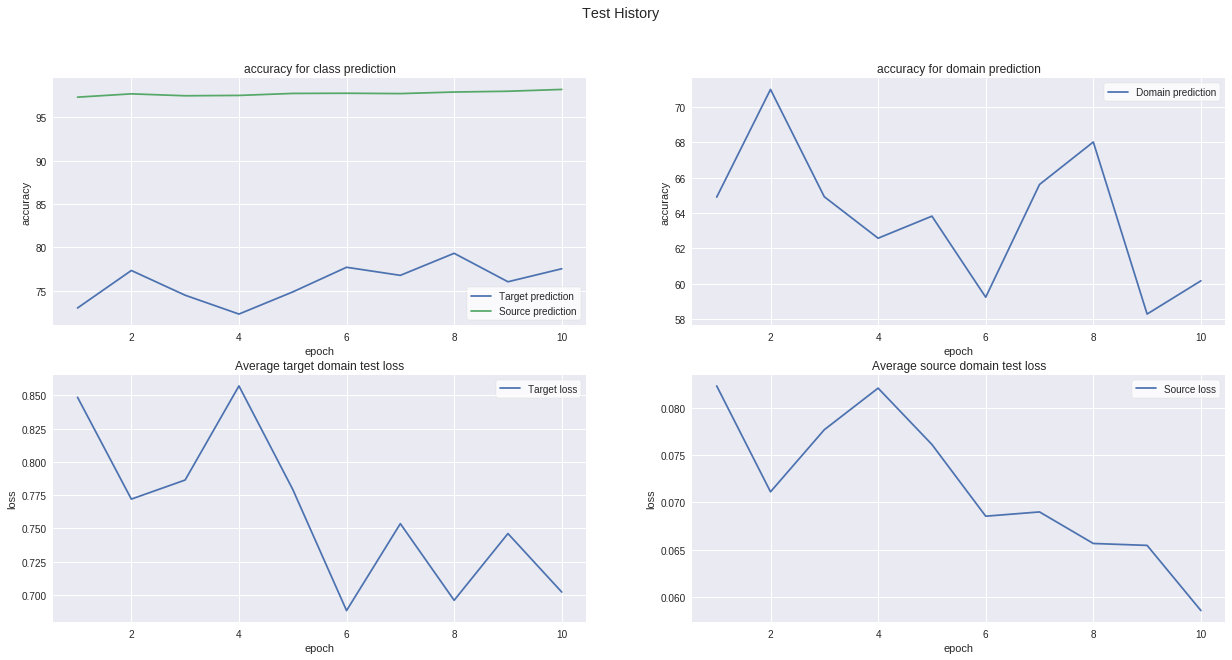

In [186]:
plots.plot_test(test_history_next)

In [34]:
transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                       ])

train_set = torchvision.datasets.SVHN(root='./data', download=True,
                                     transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)

test_set = torchvision.datasets.SVHN(root='./data', download=True,
                                     transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/train_32x32.mat


In [47]:
trainiter = iter(train_loader)
images, labels = trainiter.next()

sample = images[0]
sample.size()

torch.Size([3, 32, 32])

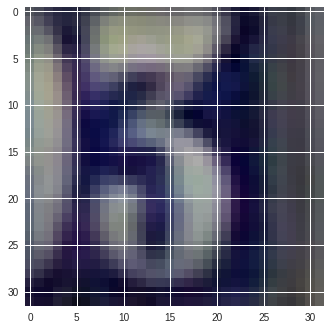

In [48]:
plt.imshow(sample.numpy().transpose(1,2,0))

In [49]:
labels[0]

tensor(3)